In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/tmp/ipykernel_2438200/4211290353.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [30]:
colors = ["#e76254", "#ef8a47", "#f7aa58", "#ffd06f", "#ffe6b7", 
          "#aadce0", "#72bcd5", "#528fad", "#376795","#1e466e"]

df = pd.read_csv("/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/check-w-bipartite-clustering-vs-beta/df_properties_weighted.csv")

title = r'$N=500,\left<k\right>=10,\beta=3,\gamma=2.7, N_f=500, \left<k_n\right>=20$'

df.head()

,dim,B_s,g_s,Ns_obs,k_s,g_n,k_n,g_f,N_f,B_bi,c,i,cb_nodes,cb_features,mean_degree_nodes
0,1,3,2.7,500,10,3.5,10,3.5,500,100.0,0.0,1,0.821205,0.817852,9.832000
1,8,3,2.7,500,10,2.1,10,3.5,500,2.8,0.0,1,0.256399,0.285810,9.454361
2,4,3,2.7,500,10,2.1,10,2.1,500,5.0,0.0,2,0.684511,0.702144,11.564000
3,6,3,2.7,500,10,3.5,10,3.5,500,50.0,0.0,0,0.257716,0.261519,10.130000
4,7,3,2.7,500,10,3.5,10,3.5,500,6.0,0.0,3,0.216700,0.214858,9.836000


In [37]:
g = sns.FacetGrid(df, row='g_n', col='g_f', hue='dim', margin_titles=True, palette='viridis', height=4)
g.map(sns.lineplot, 'B_bi', 'cb_nodes')

for ax in g.axes.flatten():
    ax.set_xscale('log')

g.add_legend(loc=(0.9, 0.3), fontsize=12)
# plt.subplots_adjust(top=0.9,right=0.8)
g.fig.suptitle(title)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-inferring-beta-25-07-24/plots/weighted_clutering_nodes_vs_beta.pdf")
plt.show()

In [38]:
g = sns.FacetGrid(df, row='g_n', col='g_f', hue='dim', margin_titles=True, palette='viridis', height=4)
g.map(sns.lineplot, 'B_bi', 'cb_features')

for ax in g.axes.flatten():
    ax.set_xscale('log')

g.add_legend(loc=(0.9, 0.3), fontsize=12)
# plt.subplots_adjust(top=0.9,right=0.8)
g.fig.suptitle(title)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-inferring-beta-25-07-24/plots/weighted_clutering_features_vs_beta.pdf")

# plt.show()


In [43]:
df['cb_nodes_rescaled'] = df.groupby(['dim', 'g_n', 'g_f'])['cb_nodes'].transform(lambda x: x / x.max())
df['cb_features_rescaled'] = df.groupby(['dim', 'g_n', 'g_f'])['cb_features'].transform(lambda x: x / x.max())

df

,dim,B_s,g_s,Ns_obs,k_s,g_n,k_n,g_f,N_f,B_bi,c,i,cb_nodes,cb_features,mean_degree_nodes,cb_rescaled,cb_nodes_rescaled,cb_features_rescaled
0,1,3,2.7,500,10,3.5,10,3.5,500,100.0,0.0,1,0.821205,0.817852,9.832000,1.000000,1.000000,1.000000
1,8,3,2.7,500,10,2.1,10,3.5,500,2.8,0.0,1,0.256399,0.285810,9.454361,0.805402,0.805402,0.846533
2,4,3,2.7,500,10,2.1,10,2.1,500,5.0,0.0,2,0.684511,0.702144,11.564000,0.922336,0.922336,0.965063
3,6,3,2.7,500,10,3.5,10,3.5,500,50.0,0.0,0,0.257716,0.261519,10.130000,0.920990,0.920990,0.953788
4,7,3,2.7,500,10,3.5,10,3.5,500,6.0,0.0,3,0.216700,0.214858,9.836000,0.904760,0.904760,0.888283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,3,3,2.7,500,10,3.5,10,2.1,500,4.0,0.0,3,0.595115,0.616491,11.242000,0.861951,0.861951,0.880259
2556,2,3,2.7,500,10,2.1,10,3.5,500,8.0,0.0,1,0.760684,0.739205,10.237395,0.920376,0.920376,0.941922
2557,8,3,2.7,500,10,3.5,10,2.1,500,6.0,0.0,0,0.309604,0.299273,10.786000,0.861811,0.861811,0.881986
2558,7,3,2.7,500,10,3.5,10,3.5,500,3.6,0.0,0,0.210691,0.209309,9.968000,0.879671,0.879671,0.865342


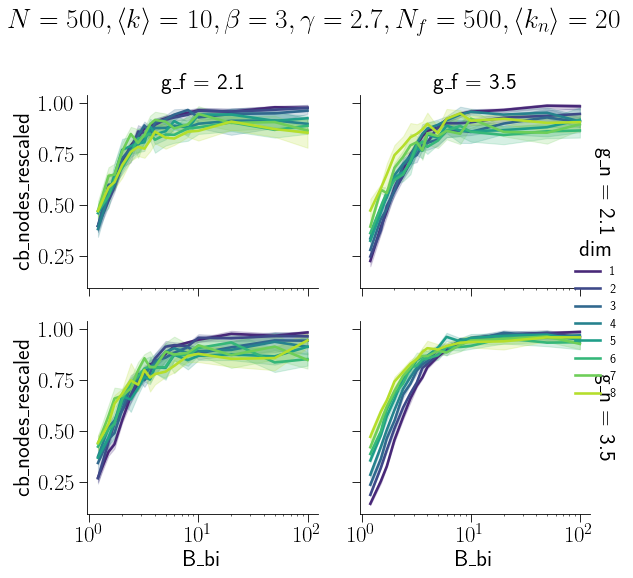

In [46]:
g = sns.FacetGrid(df, row='g_n', col='g_f', hue='dim', margin_titles=True, palette='viridis', height=4)
g.map(sns.lineplot, 'B_bi', 'cb_nodes_rescaled')

for ax in g.axes.flatten():
    ax.set_xscale('log')

g.add_legend(loc=(0.9, 0.3), fontsize=12)
# plt.subplots_adjust(top=0.9,right=0.8)
g.fig.suptitle(title)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-inferring-beta-25-07-24/plots/weighted_clutering_nodes_vs_beta_rescaled.pdf")
plt.show()

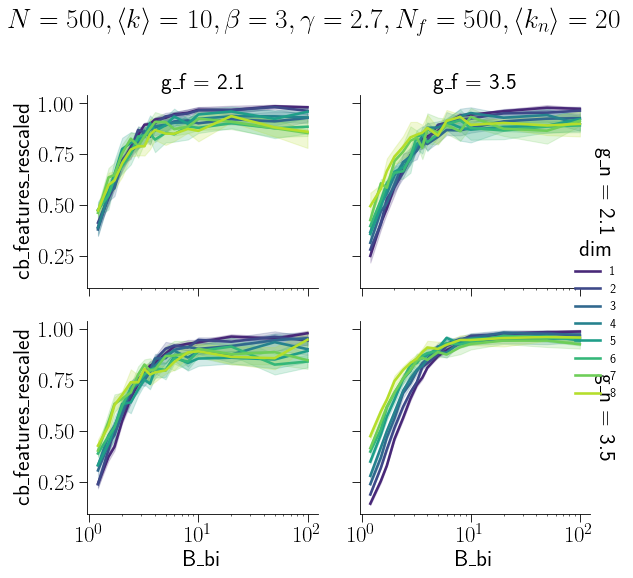

In [45]:
g = sns.FacetGrid(df, row='g_n', col='g_f', hue='dim', margin_titles=True, palette='viridis', height=4)
g.map(sns.lineplot, 'B_bi', 'cb_features_rescaled')

for ax in g.axes.flatten():
    ax.set_xscale('log')

g.add_legend(loc=(0.9, 0.3), fontsize=12)
# plt.subplots_adjust(top=0.9,right=0.8)
g.fig.suptitle(title)

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Reports/f-mercator-inferring-beta-25-07-24/plots/weighted_clutering_features_vs_beta_rescaled.pdf")
plt.show()